In [488]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn import preprocessing

In [392]:
mailout_train = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
DIAS_attributes= pd.read_excel("DIAS Attributes - Values 2017.xlsx")
print(mailout_train.shape)

(42962, 367)


c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [393]:
# the 'LNR' is unique.set LNR into index
mailout_train.set_index('LNR',inplace=True)

In [394]:

# clean the dataset
DIAS_attributes.drop(['Unnamed: 0'],axis=1,inplace=True)
if 'Attribute' in DIAS_attributes.iloc[0][0]:
    DIAS_attributes.drop(index=[0],axis=0,inplace=True)
DIAS_attributes.columns = ['Attribute','Description','Value','Meaning']
# fill in the attribute value.
attribute_name=''
# description_name=''
for i,v in DIAS_attributes.iterrows():
    if v['Attribute'] is np.nan:
        v['Attribute']=attribute_name
    else:
        attribute_name=v['Attribute']
#     if v['Description'] is np.nan:
#         v['Description']=description_name
#     else:
#         description_name=v['Description']
DIAS_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [395]:
# find out the attribute that value contains unknown.
missing_attribute_value_list=[]
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'unknown' in v['Meaning']:
            missing_attribute_value_list.append([v['Attribute'],v['Value'],v['Meaning']])

In [396]:
# find out the attribute that value contains unknown.
missing_attribute_value_list=[]
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'unknown' in v['Meaning']:
            missing_attribute_value_list.append([v['Attribute'],v['Value'],v['Meaning']])

In [397]:
def unknown2missing(df):
    ''' Input: dataframe
        Output: dataframe without the unknown value
        Process:
                replace the unknown value with the nan
    '''
    df_temp=df.copy()
    for l in missing_attribute_value_list:
        if l[0] in df.columns:
            if isinstance(l[1],int):
                df_temp[l[0]]=df[l[0]].replace(l[1],np.nan)
            else:
                for ll in l[1].split(','):
                    df_temp[l[0]]=df[l[0]].replace(int(ll),np.nan)
    return df_temp

In [398]:
mailout_train=unknown2missing(mailout_train)

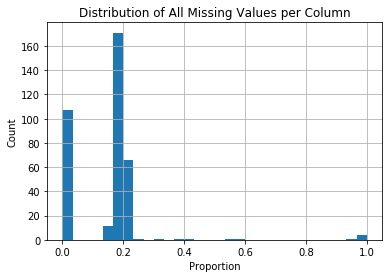

In [399]:
# col
mailout_train_col_null=(mailout_train.isnull().sum()/len(mailout_train)).sort_values(ascending=False)
mailout_train_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

In [400]:
remove_features=set(mailout_train_col_null[mailout_train_col_null>0.3].index)
print(remove_features)

{'AGER_TYP', 'KK_KUNDENTYP', 'TITEL_KZ', 'ALTER_KIND4', 'EXTSEL992', 'ALTER_KIND3', 'ALTER_HH', 'KBA05_BAUMAX', 'ALTER_KIND2', 'ALTER_KIND1'}


In [401]:
mailout_train.drop(labels=remove_features,axis=1,inplace=True)

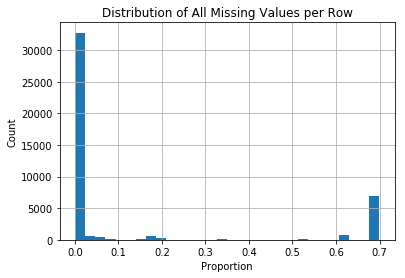

In [402]:
mailout_train_row_null=(mailout_train.isnull().mean(axis=1)).sort_values(ascending=False)
mailout_train_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [403]:
mailout_train_remove_row=mailout_train_row_null[mailout_train_row_null>0.3].index
mailout_train.drop(index=mailout_train_remove_row,axis=0,inplace=True)

In [404]:
attribute_value_number=[]
for i in mailout_train.columns:
    attribute_value_number.append((len(mailout_train[i].value_counts()),i))

In [405]:
print(sorted(attribute_value_number))

[(2, 'ANREDE_KZ'), (2, 'DSL_FLAG'), (2, 'GREEN_AVANTGARDE'), (2, 'HH_DELTA_FLAG'), (2, 'KBA05_SEG6'), (2, 'KONSUMZELLE'), (2, 'OST_WEST_KZ'), (2, 'RESPONSE'), (2, 'SOHO_KZ'), (2, 'UNGLEICHENN_FLAG'), (2, 'VERS_TYP'), (3, 'ANZ_TITEL'), (3, 'D19_TELKO_ONLINE_QUOTE_12'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'D19_VERSI_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'KKK'), (4, 'PLZ8_ANTG3'), (4, 'SHOP

In [406]:
# find out the value count bigger than 30
[x for x in attribute_value_number if x[0]>30]

[(173, 'ANZ_HAUSHALTE_AKTIV'),
 (171, 'ANZ_STATISTISCHE_HAUSHALTE'),
 (45, 'CAMEO_DEU_2015'),
 (43, 'CAMEO_INTL_2015'),
 (35, 'D19_LETZTER_KAUF_BRANCHE'),
 (1534, 'EINGEFUEGT_AM'),
 (33, 'EINGEZOGENAM_HH_JAHR'),
 (108, 'GEBURTSJAHR'),
 (1230, 'KBA13_ANZAHL_PKW'),
 (41, 'LP_LEBENSPHASE_FEIN'),
 (46, 'VERDICHTUNGSRAUM')]

In [407]:
# find out the attribute that the data types are numerical.
numerical_attribute=set()
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'numeric' in v['Meaning']:
            numerical_attribute.add(v['Attribute'])

In [408]:
print(numerical_attribute)

{'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR', 'ANZ_PERSONEN', 'ANZ_TITEL'}


In [409]:
# I considerate ANZ_STATISTISCHE_HAUSHALTE as numerical features
mailout_train['ANZ_STATISTISCHE_HAUSHALTE']
numerical_attribute.add('ANZ_STATISTISCHE_HAUSHALTE')

In [410]:
# deal with EINGEFUEGT_AM
mailout_train['EINGEFUEGT_AM']=(pd.to_datetime('2017')-pd.to_datetime(mailout_train['EINGEFUEGT_AM'])).dt.total_seconds() / (24 * 60 * 60)//365
mailout_train['EINGEFUEGT_AM'].astype(float)

LNR
1763     24.0
1771     19.0
1776     21.0
1460     24.0
1783     24.0
1789     24.0
1795     24.0
1493     19.0
2512     24.0
2513     21.0
2515     24.0
2198     24.0
2528     24.0
2554     13.0
2666     21.0
2678     24.0
11125    24.0
11440    24.0
11141    24.0
11461    24.0
10861    24.0
10879    24.0
10891    24.0
11214    24.0
10928    24.0
11251    16.0
10955    24.0
11268    24.0
10960    24.0
10971    24.0
         ... 
38618    24.0
38935    21.0
38945    24.0
38948    24.0
38958    24.0
38645    24.0
38648    19.0
38979    13.0
38980    24.0
38988    24.0
39000    24.0
38697    24.0
66638    19.0
66967    24.0
67275    24.0
67286    24.0
68563    24.0
68886    24.0
69206    24.0
69529    24.0
69834    24.0
69837    24.0
69846    20.0
70803    24.0
70807    24.0
66338    24.0
67629    24.0
68273    24.0
68581    24.0
69224    24.0
Name: EINGEFUEGT_AM, Length: 35000, dtype: float64

In [411]:
# I considerate EINGEFUEGT_AM as numerical features
numerical_attribute.add('EINGEFUEGT_AM')

In [412]:
# choose the binary features
binary_attribute=set([x[1] for x in attribute_value_number if x[0]==2])

In [413]:
print(binary_attribute)

{'KONSUMZELLE', 'GREEN_AVANTGARDE', 'UNGLEICHENN_FLAG', 'SOHO_KZ', 'HH_DELTA_FLAG', 'KBA05_SEG6', 'VERS_TYP', 'RESPONSE', 'ANREDE_KZ', 'DSL_FLAG', 'OST_WEST_KZ'}


In [414]:
mailout_train[list(binary_attribute)].head()

,KONSUMZELLE,GREEN_AVANTGARDE,UNGLEICHENN_FLAG,SOHO_KZ,HH_DELTA_FLAG,KBA05_SEG6,VERS_TYP,RESPONSE,ANREDE_KZ,DSL_FLAG,OST_WEST_KZ
LNR,,,,,,,,,,,
1763,1.0,0,0.0,0.0,0.0,0.0,2.0,0,2,1.0,W
1771,0.0,0,0.0,0.0,0.0,0.0,1.0,0,2,1.0,W
1776,0.0,1,0.0,0.0,NaN,0.0,1.0,0,1,1.0,O
1460,0.0,1,0.0,0.0,0.0,0.0,2.0,0,2,1.0,W
1783,0.0,0,0.0,0.0,0.0,0.0,1.0,0,1,1.0,W


In [415]:
binary_attribute.remove('RESPONSE')
mailout_train['KBA05_SEG6'].value_counts()

0.0    29397
1.0     4440
Name: KBA05_SEG6, dtype: int64

In [416]:
# Replace  the values of 'OST_WEST_KZ' 'VERS_TYP' 'ANREDE_KZ' with 1 and 0
# OST_WEST_KZ
mailout_train.loc[mailout_train['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_train.loc[mailout_train['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_train['ANREDE_KZ']=mailout_train['ANREDE_KZ']-1
# VERS_TYP
mailout_train['VERS_TYP']=mailout_train['VERS_TYP']-1

In [417]:
for l in binary_attribute:
    mailout_train[l].fillna(mailout_train[l].mode()[0], inplace=True)
mailout_train[list(binary_attribute)]=mailout_train[list(binary_attribute)].astype('int')

In [418]:
# multiple_categories_attribute
multiple_categories_attribute=set(mailout_train.columns)-numerical_attribute-set(['RESPONSE'])-binary_attribute

In [419]:
mailout_train[list(multiple_categories_attribute)].columns.to_series().groupby(mailout_train[list(multiple_categories_attribute)].dtypes).groups

{dtype('int64'): Index(['D19_TECHNIK', 'D19_GESAMT_ONLINE_DATUM', 'D19_KINDERARTIKEL',
        'D19_VERSAND_ANZ_12', 'FINANZ_HAUSBAUER', 'D19_WEIN_FEINKOST',
        'FINANZ_UNAUFFAELLIGER', 'SEMIO_DOM', 'D19_TELKO_ONLINE_DATUM',
        'SEMIO_REL', 'D19_REISEN', 'D19_BEKLEIDUNG_REST', 'SEMIO_SOZ',
        'D19_VERSI_ANZ_12', 'D19_BANKEN_REST', 'D19_GESAMT_OFFLINE_DATUM',
        'SEMIO_FAM', 'D19_BIO_OEKO', 'D19_BANKEN_LOKAL', 'D19_TELKO_ANZ_12',
        'D19_TELKO_ANZ_24', 'D19_HAUS_DEKO', 'D19_FREIZEIT',
        'D19_SAMMELARTIKEL', 'D19_VERSI_ONLINE_DATUM', 'D19_LEBENSMITTEL',
        'D19_BUCH_CD', 'SEMIO_TRADV', 'D19_VERSI_OFFLINE_DATUM',
        'D19_VERSICHERUNGEN', 'D19_KOSMETIK', 'SEMIO_MAT', 'D19_TELKO_REST',
        'D19_BANKEN_GROSS', 'D19_ENERGIE', 'D19_GESAMT_ANZ_12',
        'D19_TIERARTIKEL', 'SEMIO_ERL', 'D19_BANKEN_ONLINE_DATUM', 'SEMIO_RAT',
        'SEMIO_KAEM', 'SEMIO_PFLICHT', 'D19_BANKEN_ANZ_24', 'D19_VOLLSORTIMENT',
        'KOMBIALTER', 'SEMIO_LUST', 'D19_VER

In [420]:
mailout_train['CAMEO_DEU_2015'].value_counts()

6B    2445
4C    2210
3D    2148
2D    1984
4A    1675
8A    1591
3C    1543
8C    1263
7A    1234
2C    1171
8D    1164
6E    1114
8B     966
2B     937
7B     839
1D     810
5D     781
6C     758
1A     689
9D     660
2A     594
9B     514
4B     479
9A     463
5A     463
4D     445
5B     436
9C     430
5C     419
6F     399
7E     385
3B     383
7C     376
6D     375
9E     369
1E     365
3A     338
1C     313
4E     302
6A     256
5F     239
7D     210
1B     196
5E     177
XX      11
Name: CAMEO_DEU_2015, dtype: int64

In [421]:
mailout_train.drop(labels=['CAMEO_DEU_2015'],axis=1,inplace=True)

In [422]:
# deal with object
mailout_train['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
mailout_train['CAMEO_INTL_2015'].replace('XX',np.nan,inplace=True)
mailout_train['CAMEO_DEUG_2015']=mailout_train['CAMEO_DEUG_2015'].astype('float')
mailout_train['CAMEO_INTL_2015']=mailout_train['CAMEO_INTL_2015'].astype('float')
mailout_train[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].corr()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
CAMEO_DEUG_2015,1.000000,0.957033
CAMEO_INTL_2015,0.957033,1.000000


In [423]:
mailout_train.drop(labels=['CAMEO_INTL_2015'],axis=1,inplace=True)

In [424]:
mailout_train['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             9987
D19_SONSTIGE              2675
D19_VERSICHERUNGEN        2607
D19_VOLLSORTIMENT         2218
D19_HAUS_DEKO             2167
D19_BUCH_CD               2033
D19_DROGERIEARTIKEL       1085
D19_BEKLEIDUNG_GEH        1029
D19_BEKLEIDUNG_REST       1027
D19_SCHUHE                1012
D19_ENERGIE                987
D19_VERSAND_REST           786
D19_LEBENSMITTEL           762
D19_BANKEN_DIREKT          709
D19_NAHRUNGSERGAENZUNG     540
D19_TELKO_MOBILE           532
D19_TELKO_REST             528
D19_SAMMELARTIKEL          408
D19_BANKEN_GROSS           407
D19_FREIZEIT               384
D19_TECHNIK                370
D19_WEIN_FEINKOST          303
D19_RATGEBER               295
D19_KINDERARTIKEL          295
D19_DIGIT_SERV             209
D19_BANKEN_REST            202
D19_BIO_OEKO               171
D19_GARTEN                 162
D19_REISEN                 133
D19_TIERARTIKEL            114
D19_HANDWERK               110
D19_BANKEN_LOKAL            59
D19_BILD

In [425]:
multiple_categories_attribute.remove('CAMEO_DEU_2015')
multiple_categories_attribute.remove('CAMEO_INTL_2015')

In [426]:
# correlation
multiple_categories_corr = mailout_train[list(multiple_categories_attribute)].corr()

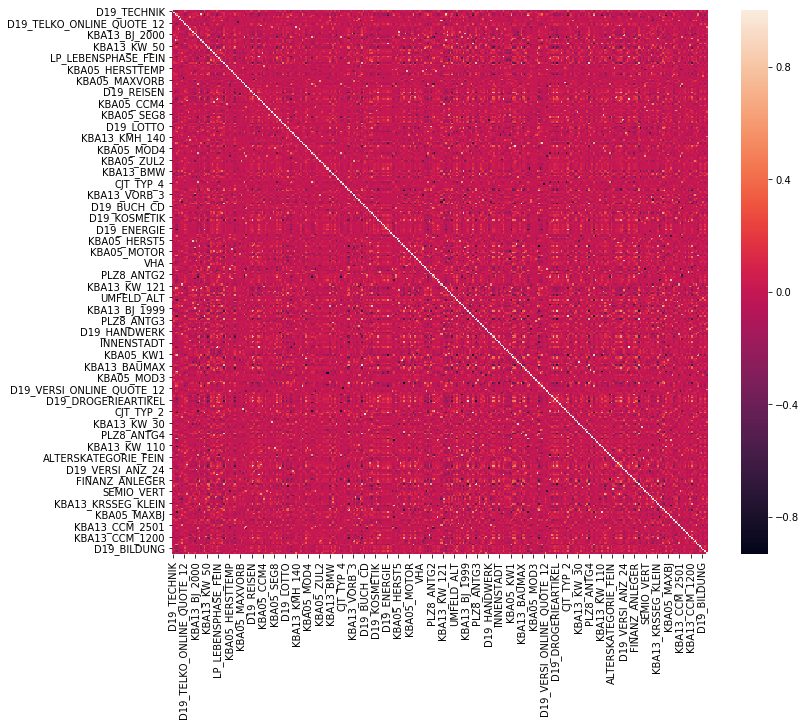

In [427]:
plt.figure(figsize=(12,10))
sns.heatmap(multiple_categories_corr)  
plt.show()

In [428]:
categories_corr_list=[]
for i, row in multiple_categories_corr.iterrows():
    corr_index=row[row.values>0.90].index
    if len(corr_index) !=0:
        corr_list=set(corr_index.tolist())
        corr_list.add(i)
        categories_corr_list.append(corr_list)

In [429]:
categories_corr_list

[{'D19_TECHNIK'},
 {'KBA13_SEG_MITTELKLASSE'},
 {'VK_DISTANZ', 'VK_ZG11'},
 {'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM'},
 {'KBA13_FIAT'},
 {'KBA13_KW_90'},
 {'KBA13_KMH_211', 'KBA13_KMH_250'},
 {'D19_TELKO_ONLINE_QUOTE_12'},
 {'D19_KINDERARTIKEL'},
 {'KBA13_SEG_MINIVANS'},
 {'KBA13_KMH_0_140'},
 {'KBA13_HERST_EUROPA'},
 {'KBA13_SEG_SONSTIGE'},
 {'KBA13_HALTER_40'},
 {'KBA13_BJ_2000'},
 {'KBA13_HALTER_30'},
 {'CJT_TYP_5'},
 {'KBA13_HALTER_55'},
 {'VK_DISTANZ', 'VK_ZG11'},
 {'EINGEZOGENAM_HH_JAHR'},
 {'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'},
 {'KBA13_KW_50'},
 {'FINANZ_HAUSBAUER'},
 {'ARBEIT'},
 {'KBA05_DIESEL'},
 {'D19_WEIN_FEINKOST'},
 {'KBA05_KW3'},
 {'KBA13_TOYOTA'},
 {'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_LEBENSPHASE_FEIN',
  'LP_LEBENSPHASE_GROB'},
 {'FINANZ_UNAUFFAELLIGER'},
 {'KBA05_CCM3'},
 {'KBA13_KRSHERST_BMW_BENZ'},
 {'KBA13_ANTG4'},
 {'KBA05_MOTRAD'},
 {'KBA13_KW_60'},
 {'KBA05_HERSTTEMP'},
 {'SEMIO_DOM'},
 {'KBA13_VORB_1'},
 {'KB

In [430]:
# remove duplicate
categories_corr_list_ = []
for i in categories_corr_list:
    if len(categories_corr_list_)>0:
        add_flag=1
        for j in categories_corr_list_:
            if len(i-j)==0:
                add_flag=0
        if add_flag==1:
            categories_corr_list_.append(i)
    else:
        categories_corr_list_.append(i)
print(categories_corr_list_) 

[{'D19_TECHNIK'}, {'KBA13_SEG_MITTELKLASSE'}, {'VK_DISTANZ', 'VK_ZG11'}, {'D19_VERSAND_ONLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM'}, {'KBA13_FIAT'}, {'KBA13_KW_90'}, {'KBA13_KMH_211', 'KBA13_KMH_250'}, {'D19_TELKO_ONLINE_QUOTE_12'}, {'D19_KINDERARTIKEL'}, {'KBA13_SEG_MINIVANS'}, {'KBA13_KMH_0_140'}, {'KBA13_HERST_EUROPA'}, {'KBA13_SEG_SONSTIGE'}, {'KBA13_HALTER_40'}, {'KBA13_BJ_2000'}, {'KBA13_HALTER_30'}, {'CJT_TYP_5'}, {'KBA13_HALTER_55'}, {'EINGEZOGENAM_HH_JAHR'}, {'D19_VERSAND_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_GESAMT_ANZ_12'}, {'KBA13_KW_50'}, {'FINANZ_HAUSBAUER'}, {'ARBEIT'}, {'KBA05_DIESEL'}, {'D19_WEIN_FEINKOST'}, {'KBA05_KW3'}, {'KBA13_TOYOTA'}, {'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB'}, {'FINANZ_UNAUFFAELLIGER'}, {'KBA05_CCM3'}, {'KBA13_KRSHERST_BMW_BENZ'}, {'KBA13_ANTG4'}, {'KBA05_MOTRAD'}, {'KBA13_KW_60'}, {'KBA05_HERSTTEMP'}, {'SEMIO_DOM'}, {'KBA13_VORB_1'}, {'KBA13_MAZDA'}, {'HH_EINKOMMEN_SCORE'}, {'KBA13_KW_80'}, {'D19_TELKO_ONLIN

In [431]:
[x for x in categories_corr_list_ if len(x)>1]

[{'VK_DISTANZ', 'VK_ZG11'},
 {'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM'},
 {'KBA13_KMH_211', 'KBA13_KMH_250'},
 {'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'},
 {'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_LEBENSPHASE_FEIN',
  'LP_LEBENSPHASE_GROB'},
 {'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSAND_OFFLINE_DATUM'},
 {'KBA13_GBZ', 'PLZ8_GBZ'},
 {'KBA13_BAUMAX', 'PLZ8_BAUMAX'},
 {'KBA13_HHZ', 'PLZ8_HHZ'},
 {'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12'},
 {'KBA13_ANTG1', 'PLZ8_ANTG1'},
 {'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'},
 {'KBA13_ANTG3', 'PLZ8_ANTG3'},
 {'KBA13_ALTERHALTER_61', 'KBA13_HALTER_66'},
 {'LP_STATUS_FEIN', 'LP_STATUS_GROB'},
 {'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_24'},
 {'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12'},
 {'KBA13_FAB_SONSTIGE', 'KBA13_HERST_SONST'}]

In [432]:
# drop some features
l=['KBA13_HALTER_66','D19_VERSAND_OFFLINE_DATUM','VK_ZG11','D19_VERSAND_ANZ_12','D19_VERSAND_ANZ_24','D19_VERSAND_ONLINE_QUOTE_12','KBA13_KMH_250','LP_STATUS_GROB' ,'PLZ8_ANTG1','D19_VERSAND_ONLINE_DATUM','PLZ8_BAUMAX','PLZ8_GBZ','PLZ8_ANTG3','PLZ8_HHZ','D19_GESAMT_ANZ_24','LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','KBA13_HERST_SONST']
mailout_train.drop(labels=l,axis=1,inplace=True)

In [433]:
multiple_categories_attribute=multiple_categories_attribute-set(['KBA13_HALTER_66','D19_VERSAND_OFFLINE_DATUM','VK_ZG11','D19_VERSAND_ANZ_12','D19_VERSAND_ANZ_24','D19_VERSAND_ONLINE_QUOTE_12','KBA13_KMH_250','LP_STATUS_GROB' ,'PLZ8_ANTG1','D19_VERSAND_ONLINE_DATUM','PLZ8_BAUMAX','PLZ8_GBZ','PLZ8_ANTG3','PLZ8_HHZ','D19_GESAMT_ANZ_24','LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','KBA13_HERST_SONST'])

In [434]:
attribute_value_number=[]
for i in mailout_train.columns:
    attribute_value_number.append((len(mailout_train[i].value_counts()),i))
print(sorted(attribute_value_number))

[(2, 'ANREDE_KZ'), (2, 'DSL_FLAG'), (2, 'GREEN_AVANTGARDE'), (2, 'HH_DELTA_FLAG'), (2, 'KBA05_SEG6'), (2, 'KONSUMZELLE'), (2, 'OST_WEST_KZ'), (2, 'RESPONSE'), (2, 'SOHO_KZ'), (2, 'UNGLEICHENN_FLAG'), (2, 'VERS_TYP'), (3, 'ANZ_TITEL'), (3, 'D19_TELKO_ONLINE_QUOTE_12'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'D19_VERSI_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'KKK'), (4, 'SHOPPER_TYP'), (5, 'ALT

In [435]:
numerical_attribute

{'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'EINGEFUEGT_AM',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR'}

In [436]:
# find out the value count bigger than 30
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute

{'D19_LETZTER_KAUF_BRANCHE', 'EINGEZOGENAM_HH_JAHR', 'VERDICHTUNGSRAUM'}

In [437]:
# fill the missing data in numerical_attribute
for l in numerical_attribute:
    mailout_train[l]=mailout_train[l].fillna(value=round(mailout_train[l].mean()))

In [438]:
# scale the numerical attribute
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(mailout_train[list(numerical_attribute)]) 
mailout_train_numerical_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute),index=mailout_train.index)

In [439]:
# drop the numerical featrures
mailout_train.drop(labels=numerical_attribute,axis=1,inplace=True)

In [440]:
mailout_train=pd.concat([mailout_train_numerical_scaled_df, mailout_train], axis=1)

In [441]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 1763 to 69224
Columns: 335 entries, ANZ_HH_TITEL to ALTERSKATEGORIE_GROB
dtypes: float64(245), int32(10), int64(79), object(1)
memory usage: 88.4+ MB


In [442]:
mailout_train[list(multiple_categories_attribute)]=mailout_train[list(multiple_categories_attribute)].astype('str')

In [443]:
mailout_train_dummy=pd.get_dummies(data=mailout_train[list(multiple_categories_attribute)])

In [444]:
mailout_train_dummy.shape

(35000, 2102)

# Insert processing the Test DATA for dummy columns


In [460]:
mailout_test = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.set_index('LNR',inplace=True)
mailout_test=unknown2missing(mailout_test)
mailout_test['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
mailout_test.drop(labels=(set(mailout_test.columns)-numerical_attribute-multiple_categories_attribute-binary_attribute),axis=1,inplace=True)

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [465]:
# binary
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_test['ANREDE_KZ']=mailout_test['ANREDE_KZ']-1
# VERS_TYP
mailout_test['VERS_TYP']=mailout_test['VERS_TYP']-1

for l in binary_attribute:
    mailout_test[l].fillna(mailout_test[l].mode()[0], inplace=True)
mailout_test[list(binary_attribute)]=mailout_test[list(binary_attribute)].astype('int')
mailout_test['EINGEFUEGT_AM']=(pd.to_datetime('2017')-pd.to_datetime(mailout_test['EINGEFUEGT_AM'])).dt.total_seconds() / (24 * 60 * 60)//365
mailout_test['EINGEFUEGT_AM'].astype(float)
# fill the missing data in numerical_attribute
for l in numerical_attribute:
    mailout_test[l]=mailout_test[l].fillna(value=round(mailout_test[l].mean()))
# scale the numerical attribute
test_scaler = preprocessing.StandardScaler()
test_scaled = test_scaler.fit_transform(mailout_test[list(numerical_attribute)]) 
mailout_test_numerical_scaled_df=pd.DataFrame(test_scaled, columns=list(numerical_attribute),index=mailout_test.index)
# drop the numerical featrures
mailout_test.drop(labels=numerical_attribute,axis=1,inplace=True)
mailout_test=pd.concat([mailout_test_numerical_scaled_df, mailout_test], axis=1)
mailout_test.info()

In [467]:
mailout_test[list(multiple_categories_attribute)]=mailout_test[list(multiple_categories_attribute)].astype('str')
mailout_test_dummy=pd.get_dummies(data=mailout_test[list(multiple_categories_attribute)])
mailout_test_dummy.shape

(42833, 2234)

In [468]:
dummy_set=set(mailout_test_dummy.columns)&set(mailout_train_dummy.columns)

In [469]:
mailout_test.drop(labels=multiple_categories_attribute,axis=1,inplace=True)
mailout_test=pd.concat([mailout_test_dummy[list(dummy_set)], mailout_test], axis=1)

In [470]:
mailout_test.shape

(42833, 2115)

# Back to Train Data

In [445]:
mailout_train.drop(labels=multiple_categories_attribute,axis=1,inplace=True)

In [446]:
mailout_train=pd.concat([mailout_train_dummy[list(dummy_set)], mailout_train], axis=1)

In [447]:
mailout_train.shape

(35000, 2116)

In [448]:
mailout_train['RESPONSE'].value_counts()

0    34565
1      435
Name: RESPONSE, dtype: int64

In [449]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [450]:
mailout_train.columns.to_series().groupby(mailout_train.dtypes).groups

{dtype('uint8'): Index(['KBA05_HERST3_5.0', 'KBA05_HERST1_5.0', 'D19_KOSMETIK_6',
        'KBA13_FAB_ASIEN_4.0', 'D19_KOSMETIK_0', 'EINGEZOGENAM_HH_JAHR_2014.0',
        'KBA05_ZUL2_4.0', 'UMFELD_ALT_2.0', 'KBA13_BJ_2009_5.0', 'KBA13_VW_2.0',
        ...
        'CJT_GESAMTTYP_4.0', 'KBA13_BJ_2009_2.0', 'KBA13_KW_30_3.0',
        'KBA13_BJ_2004_3.0', 'D19_GESAMT_ANZ_12_2', 'SEMIO_TRADV_1',
        'KBA05_SEG1_0.0', 'KBA05_ALTER1_nan', 'RETOURTYP_BK_S_4.0',
        'KBA13_KW_121_3.0'],
       dtype='object', length=2096),
 dtype('int32'): Index(['DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_SEG6',
        'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP',
        'ANREDE_KZ'],
       dtype='object'),
 dtype('int64'): Index(['RESPONSE'], dtype='object'),
 dtype('float64'): Index(['ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV',
        'GEBURTSJAHR', 'EINGEFUEGT_AM', 'MIN_GEBAEUDEJAHR', 'ANZ_PERSONEN',
        'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_T

In [451]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.05, random_state=0)

In [477]:
len(y_preds[:,1])

1750

In [452]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data
from torch.autograd import Variable
torch.set_default_dtype(torch.float64)

In [453]:
torch_tensor_X_train = torch.tensor(X_train.values)
torch_tensor_y_train = torch.tensor(y_train.values,dtype=torch.long)
torch_tensor_X_val = torch.tensor(X_val.values)
torch_tensor_y_val = torch.tensor(y_val.values,dtype=torch.long)

In [454]:
X_train.shape

(33250, 2115)

In [455]:
train_batch_size =33250
test_batch_size =35000 -33250

In [456]:
train = torch.utils.data.TensorDataset(torch_tensor_X_train,torch_tensor_y_train)
test = torch.utils.data.TensorDataset(torch_tensor_X_val,torch_tensor_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_batch_size, shuffle = False)

In [457]:
class Net(torch.nn.Module):  # 3 layer net
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim): 
        super(Net, self).__init__()  
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1),nn.Dropout(0.5), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2),nn.Dropout(0.5), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
 
    def forward(self, x): 
#         x = F.relu(self.hidden(x)) 
#         x = self.out(x) 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [458]:
model = Net(in_dim=2115, n_hidden_1=512,n_hidden_2=10, out_dim=2)  # two classification has two n_features
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  
criterion = torch.nn.CrossEntropyLoss()  # loss_function

In [459]:
epochs =80
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for x1,y1 in train_loader:
        if torch.cuda.is_available():
            x1 = x1.cuda()
            y1 = y1.cuda()
        else:
            x1 = Variable(x1)
            y1= Variable(y1)
        out = model(x1)  
        loss = criterion(out, y1)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for x2,y2 in test_loader:
                if torch.cuda.is_available():
                    x2 = x2.cuda()
                    y2 = y2.cuda()
                else:
                    x2 = Variable(x2)
                    y2= Variable(y2)
                log_ps = model(x2)
                test_loss += criterion(log_ps,y2)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == y2.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

        prediction = torch.max(out, 1)[1].cpu()  ##返回每一行中最大值的那个元素，且返回其索引  torch.max()[1]， 只返回最大值的每个索引
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y_train_Variable.data.numpy()
        print(accuracy)

Epoch: 1/80..  Training Loss: 0.591..  Test Loss: 0.581..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 2/80..  Training Loss: 0.588..  Test Loss: 0.579..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 3/80..  Training Loss: 0.585..  Test Loss: 0.577..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 4/80..  Training Loss: 0.583..  Test Loss: 0.575..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 5/80..  Training Loss: 0.580..  Test Loss: 0.574..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 6/80..  Training Loss: 0.578..  Test Loss: 0.572..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 7/80..  Training Loss: 0.576..  Test Loss: 0.570..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 8/80..  Training Loss: 0.573..  Test Loss: 0.568..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 9/80..  Training Loss: 0.572..  Test Loss: 0.566..  Test Accuracy

Epoch: 72/80..  Training Loss: 0.449..  Test Loss: 0.454..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 73/80..  Training Loss: 0.449..  Test Loss: 0.452..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 74/80..  Training Loss: 0.447..  Test Loss: 0.451..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 75/80..  Training Loss: 0.445..  Test Loss: 0.450..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 76/80..  Training Loss: 0.444..  Test Loss: 0.448..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 77/80..  Training Loss: 0.442..  Test Loss: 0.447..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 78/80..  Training Loss: 0.441..  Test Loss: 0.445..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 79/80..  Training Loss: 0.439..  Test Loss: 0.444..  Test Accuracy: 0.987
tensor(0.9874, dtype=torch.float32)
Epoch: 80/80..  Training Loss: 0.438..  Test Loss: 0.442..  Test

In [471]:
# ready for predict
test_dataset = torch.tensor(mailout_test.values)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 42833, shuffle = False)
results = []
with torch.no_grad():
    model.eval()
    for t in new_test_loader:
        if torch.cuda.is_available():
            t = t.cuda()
        output = model(t)
        output=output.cpu()
        sm = torch.nn.Softmax()
        probabilities = sm(output) 
        print(probabilities.numpy()[:,1]) 
        results=probabilities.numpy()[:,1]
        #Converted to probabilities
#         ps = torch.exp(output)
#         top_p, top_class = ps.topk(1, dim = 1)
#         results += top_class.numpy().tolist()

In [473]:
submissions=pd.DataFrame({"LNR": mailout_test.index,
                         "RESPONSE": results})
submissions.to_csv("my_submissions.csv", index=False, header=True)

In [474]:
submissions['RESPONSE'].value_counts()

0.366791    1991
0.366742    1226
0.370138     891
0.368373     768
0.370701     459
0.372552     303
0.367157      39
0.368464       2
0.353095       1
0.362472       1
0.384476       1
0.355141       1
0.356501       1
0.292397       1
0.340887       1
0.379575       1
0.292109       1
0.335861       1
0.328021       1
0.367447       1
0.339651       1
0.365696       1
0.354771       1
0.361988       1
0.340517       1
0.365175       1
0.361618       1
0.338062       1
0.324917       1
0.375256       1
            ... 
0.340650       1
0.336991       1
0.342146       1
0.346667       1
0.353399       1
0.360522       1
0.365489       1
0.369527       1
0.368819       1
0.372408       1
0.323706       1
0.344248       1
0.363249       1
0.359177       1
0.331319       1
0.354299       1
0.325287       1
0.345166       1
0.330714       1
0.339510       1
0.342860       1
0.371964       1
0.365370       1
0.337457       1
0.322199       1
0.325724       1
0.340354       1
0.392696      

In [475]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_preds = clf.predict_proba(X_val)
score = metrics.roc_auc_score(y_val,y_preds[:,1])
print(score)

0.7052819865319865


In [480]:
clf = LogisticRegression(random_state=0).fit(X, y)
lr_preds = clf.predict_proba(mailout_test)

In [481]:
lr_submissions=pd.DataFrame({"LNR": mailout_test.index,
                         "RESPONSE": lr_preds[:,1]})
lr_submissions.to_csv("lr_submissions.csv", index=False, header=True)

In [482]:
lr_submissions['RESPONSE'].value_counts()

1.070323e-03    1991
8.763676e-04    1226
1.208737e-03     891
5.000425e-04     768
9.897234e-04     459
5.647493e-04     303
2.172887e-03       2
5.006579e-04       1
3.209627e-04       1
2.120589e-04       1
6.424551e-03       1
4.651421e-04       1
1.546498e-03       1
4.414462e-04       1
1.052922e-04       1
3.848602e-06       1
1.188417e-02       1
1.461574e-03       1
6.824343e-03       1
8.018289e-06       1
4.776000e-05       1
3.033616e-03       1
2.290750e-05       1
2.265639e-03       1
7.164105e-04       1
9.807997e-04       1
3.001690e-02       1
2.203273e-04       1
4.674406e-02       1
1.975116e-07       1
                ... 
4.182335e-04       1
4.417655e-06       1
1.316969e-03       1
3.309131e-04       1
1.232708e-02       1
7.687355e-05       1
2.536048e-04       1
1.444724e-04       1
5.923558e-03       1
8.186754e-01       1
7.043584e-03       1
5.161699e-05       1
9.924656e-06       1
6.048657e-04       1
8.869745e-06       1
4.043029e-03       1
4.212837e-03 

In [489]:
lgbm_clf = lgb.LGBMClassifier(objective='binary', metric='auc')
lgbm_clf.get_params()


param_grid = {'learning_rate': [0.01],
              'num_iterations': [200],
              'boosting_type': ['gbdt','dart'],
              'num_leaves': [62],
              'random_state': [42]}

start_time = time.time()

lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, scoring='roc_auc', cv=5)
lgbm_result = lgbm.fit(X, y)

c:\program files\python3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\program files\python3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\program files\python3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\program files\python3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\program files\python3\lib\site-packages\lightgbm\engine.py:118: U

In [492]:
lgbm_preds = lgbm.predict_proba(mailout_test)
lgbm_submission = pd.DataFrame({'LNR':mailout_test.index, 'RESPONSE':lgbm_preds[:,0]})
lgbm_submission.to_csv("lgbm_submission.csv", index=False, header=True)